# Exámen Parcial : Covid-19 en Arequipa
### Alumno: Renzo Alessandro Sucari Velásquez

#### **DataSet**: covid-19-peru-data.csv

*   **country**: Peru (país)
*   iso3c: PER (código ISO de 3 letras para Perú)
*   **region**: Departamento del Perú (sólo a partir del 2020-03-13)
*   date: Fecha en formato ISO (YYYY-MM-DD)
*   **confirmed**: Casos confirmados
*   **deaths**: Decesos
*   **recovered**: Recuperados
*   **total_tests**: Número total de pruebas
*   **negative_tests**: Casos descartados/negativos
*   **pcr_test_positive**: Casos detectados con pruebas moleculares
*   **serological_test_positive**: Casos detectados con pruebas serológicas ("pruebas rápidas")
*   **pcr_serological_test_positive**: Casos detectados con pruebas moleculares y serológicas ("pruebas rápidas")





### Cargamos las Librerias

In [1]:
import pandas as pd # Manipulación de Estructuras (suma, resta, multiplicacion, etc.)
import numpy as np  # Manipulación de CSV
import random 
import matplotlib.pyplot as plt # Gráficos
import datetime     # Manejo de la fecha

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

file = "covid-19-peru-data"

### Lectura de los Datos

In [2]:
def LeerDatos(filename : str):
  data = pd.read_csv(filename + ".csv", sep =',', header = 0)
  return data

In [3]:
data = LeerDatos(file)
data.head()

,country,iso3c,region,date,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
0,Peru,PER,NaN,2020-03-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN,NaN
1,Peru,PER,NaN,2020-03-07,6.0,NaN,NaN,NaN,NaN,NaN,NaN,213.0,NaN,NaN,NaN,NaN
2,Peru,PER,NaN,2020-03-09,9.0,NaN,NaN,NaN,NaN,NaN,NaN,309.0,NaN,NaN,NaN,NaN
3,Peru,PER,NaN,2020-03-10,11.0,NaN,NaN,NaN,NaN,NaN,NaN,335.0,NaN,NaN,NaN,NaN
4,Peru,PER,NaN,2020-03-11,17.0,NaN,NaN,NaN,NaN,NaN,NaN,697.0,NaN,NaN,NaN,NaN


In [4]:
regiones = data.groupby(['region'])
arequipa_datos = regiones.get_group('Arequipa')
arequipa_datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580 entries, 6 to 15281
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        580 non-null    object 
 1   iso3c                          580 non-null    object 
 2   region                         580 non-null    object 
 3   date                           580 non-null    object 
 4   confirmed                      573 non-null    float64
 5   deaths                         550 non-null    float64
 6   recovered                      0 non-null      float64
 7   total_pcr                      74 non-null     float64
 8   total_serological              74 non-null     float64
 9   total_ag                       74 non-null     float64
 10  total_tests                    519 non-null    float64
 11  negative_tests                 519 non-null    float64
 12  pcr_test_positive              545 non-null    f

In [5]:
arequipa_datos.describe()

,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
count,573.000000,550.000000,0.0,74.000000,74.000000,74.000000,5.190000e+02,5.190000e+02,545.000000,545.000000,280.000000,2.0
mean,53134.087260,3224.656364,NaN,346427.243243,306373.094595,499111.810811,4.958349e+05,4.371906e+05,11364.922936,34471.627523,19513.082143,1.0
std,37795.412965,3489.503407,NaN,25503.928182,984.379885,47270.107281,3.678202e+05,3.334223e+05,8830.733112,17208.443125,15074.562311,0.0
min,2.000000,1.000000,NaN,305180.000000,304481.000000,417803.000000,1.666800e+04,1.587800e+04,69.000000,8.000000,5.000000,1.0
25%,17191.000000,1070.500000,NaN,323807.250000,305614.500000,459534.250000,2.134960e+05,1.748465e+05,4261.000000,26736.000000,4631.250000,1.0
50%,48279.000000,1655.000000,NaN,345293.000000,306376.500000,498748.000000,3.603360e+05,3.079180e+05,8078.000000,41353.000000,16450.500000,1.0
75%,80377.000000,2876.500000,NaN,368399.500000,307227.250000,540273.750000,7.784020e+05,6.906620e+05,18676.000000,47174.000000,36512.250000,1.0
max,114992.000000,9667.000000,NaN,390189.000000,307912.000000,576903.000000,1.275004e+06,1.160012e+06,26466.000000,49519.000000,39007.000000,1.0


### Visualización de los datos

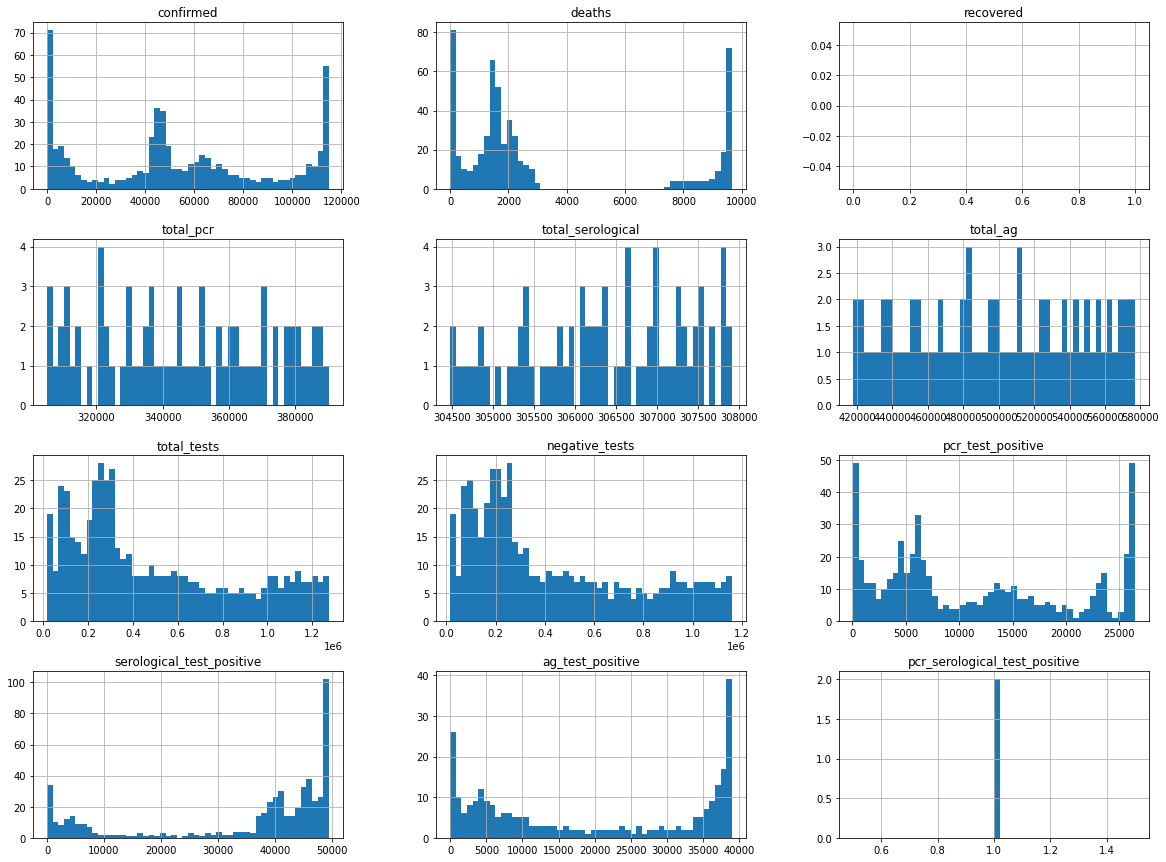

In [6]:
# Matplotlib: Distribuciones de cada variable
%matplotlib inline
import matplotlib.pyplot as plt
arequipa_datos.hist(bins=50, figsize=(20,15))
plt.show()

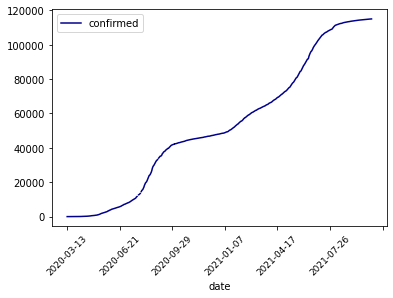

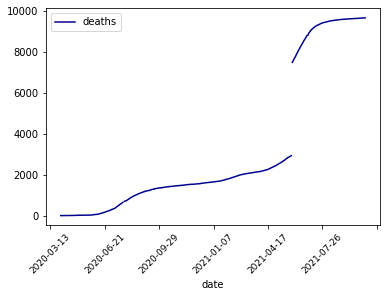

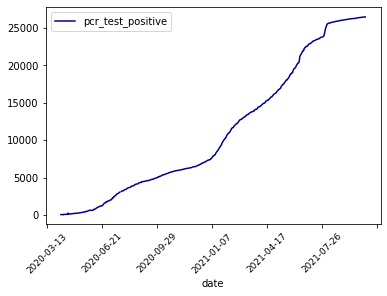

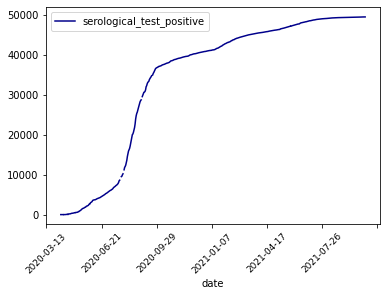

In [7]:
arequipa_datos.plot.line(x='date',y='confirmed', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
arequipa_datos.plot.line(x='date',y='deaths', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
arequipa_datos.plot.line(x='date',y='pcr_test_positive', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
arequipa_datos.plot.line(x='date',y='serological_test_positive', c='DarkBlue')
plt.xticks(fontsize = 9, rotation=45)
#save_fig("attribute_histogram_plots")
plt.show()

In [8]:
arequipa_datos.drop(labels = ['recovered','negative_tests','pcr_serological_test_positive'], axis = 1)
arequipa_datos.reset_index()

,index,country,iso3c,region,date,confirmed,deaths,recovered,total_pcr,total_serological,total_ag,total_tests,negative_tests,pcr_test_positive,serological_test_positive,ag_test_positive,pcr_serological_test_positive
0,6,Peru,PER,Arequipa,2020-03-13,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,Peru,PER,Arequipa,2020-03-14,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,Peru,PER,Arequipa,2020-03-15,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30,Peru,PER,Arequipa,2020-03-16,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41,Peru,PER,Arequipa,2020-03-17,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,15173,Peru,PER,Arequipa,2021-10-09,114912.0,9665.0,NaN,385424.0,307807.0,569677.0,1262908.0,1147996.0,26445.0,49512.0,38955.0,NaN
576,15200,Peru,PER,Arequipa,2021-10-10,114929.0,9665.0,NaN,386162.0,307817.0,571592.0,1265571.0,1150642.0,26446.0,49514.0,38969.0,NaN
577,15227,Peru,PER,Arequipa,2021-10-11,114940.0,9666.0,NaN,387239.0,307829.0,572040.0,1267108.0,1152168.0,26448.0,49515.0,38977.0,NaN
578,15254,Peru,PER,Arequipa,2021-10-12,114967.0,9666.0,NaN,388084.0,307879.0,574533.0,1270496.0,1155529.0,26454.0,49519.0,38994.0,NaN


In [9]:
# Pandas: Accedemos a un grupo de columnas por etiqueta
fechas = arequipa_datos.loc[:,['date']]
confimados = arequipa_datos.loc[:,['confirmed']]
fallecidos = arequipa_datos.loc[:,['deaths']]
recuperados = arequipa_datos.loc[:,['recovered']]

In [10]:
confimados_sum = confimados.iloc[-1]
fallecidos_sum = fallecidos.iloc[-1]
recuperados_sum = recuperados.iloc[-1]

In [11]:
# Pandas: Conviertimos el DataFrame en una array NumPy.
arequipa_casos = confimados.to_numpy()
arequipa_fallecidos = fallecidos.to_numpy()
arequipa_recuperados = recuperados.to_numpy()
arequipa_activos = arequipa_casos - arequipa_fallecidos - arequipa_recuperados
tasa_mortalidad = arequipa_fallecidos / arequipa_casos
tasa_recuperacion = arequipa_recuperados/ arequipa_casos

In [12]:
def incremento_diario(data):
    diario = []
    diario.append(data[0])
    for i in range(1,len(data)):
            diario.append(data[i]-data[i-1])
    return diario  

In [13]:
incremento_diario_arequipa = incremento_diario(arequipa_casos)
fallecidos_diarios_arequipa = incremento_diario(arequipa_fallecidos)
recuperados_diarios_arequipa = incremento_diario(arequipa_recuperados)

### La predicción debe realizarse en un rango del 18 agosto al 11 de octubre 2021.

In [14]:
days_since_18_8 = np.array([range(len(fechas))]).reshape(-1,1)

In [15]:
dias_futuros = 54
pronostico_futuro = np.array([range(len(fechas)+dias_futuros)]).reshape(-1,1)
adjusted_dates = pronostico_futuro[:-54]

In [16]:
inicio = '18/08/2021'
fecha_de_inicio = datetime.datetime.strptime(inicio, '%d/%m/%Y')
fechas_pronostico_futuras = []
for i in range(len(pronostico_futuro)):
    fechas_pronostico_futuras.append((fecha_de_inicio + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

### Preparamos los datos para los algoritmos de Machine Learning

#### Reemplazamos los datos NaN con ceros

In [17]:
# AREQUIPA: Reemplazar NaN con cero
arequipa_casos = np.nan_to_num(arequipa_casos, np.nan)
arequipa_fallecidos = np.nan_to_num(arequipa_fallecidos, np.nan)

# Sklearn: Division de los datos: train(60%) y test(40%) 
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, arequipa_casos, test_size=0.42, shuffle=False)
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, arequipa_fallecidos, test_size=0.42, shuffle=False)

# Suport Vector Machine (SVM)

#### SVM: Para casos Confirmados y Fallecimientos



In [18]:
# Sklearn: SVM

# SVM para casos confirmados
svm_confirmados = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1.5,degree=4, C=.1)
svm_confirmados.fit(X_train_confirmados, y_train_confirmados)       # Entrenar
svm_pred_confirmados = svm_confirmados.predict(pronostico_futuro)   # Predecir

# SVM para fallecidos
svm_fallecidos = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1.5,degree=4, C=.1)
svm_fallecidos.fit(X_train_fallecidos, y_train_fallecidos)          # Entrenar
svm_pred_fallecidos = svm_fallecidos.predict(pronostico_futuro)     # Predecir

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Calculo del Error

Error Absoluto Medio (MAE): 256371.67107644439
Error Cuadrático Medio(MSE): 96323178657.83179


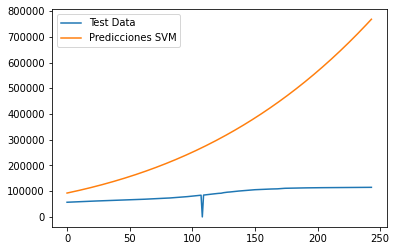

In [19]:
# Calculo del Error: Para prediccion casos
svm_test_confirmados = svm_confirmados.predict(X_test_confirmados)

plt.plot(y_test_confirmados)
plt.plot(svm_test_confirmados)
plt.legend(['Test Data', 'Predicciones SVM'])
print('Error Absoluto Medio (MAE):', mean_absolute_error(svm_test_confirmados, y_test_confirmados))
print('Error Cuadrático Medio(MSE):', mean_squared_error(svm_test_confirmados, y_test_confirmados))

Error Absoluto Medio (MAE): 26796.70814196714
Error Cuadrático Medio(MSE): 970322362.4183229


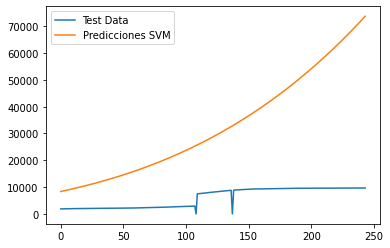

In [20]:
# Calculo del error: Para prediccion muertes
svm_test_pred_fallecidos = svm_fallecidos.predict(X_test_fallecidos) 

plt.plot(y_test_fallecidos)
plt.plot(svm_test_pred_fallecidos)
plt.legend(['Test Data', 'Predicciones SVM'])
print('Error Absoluto Medio (MAE):', mean_absolute_error(svm_test_pred_fallecidos, y_test_fallecidos))
print('Error Cuadrático Medio(MSE):', mean_squared_error(svm_test_pred_fallecidos, y_test_fallecidos))

# Regresión Polinomial (RP)

### Transformación de los datos para RP

In [21]:
# Transformacion de data para Regresion Polinomial
poly = PolynomialFeatures(degree=2)
# El modelo aprende (la media y la varianza): Casos
poly_X_train_confirmados = poly.fit_transform(X_train_confirmados)  # Para entrenar
poly_X_test_confirmados = poly.fit_transform(X_test_confirmados)    # Para predecir
# El modelo aprende (la media y la varianza): Fallecidos
poly_X_train_fallecidos = poly.fit_transform(X_train_fallecidos)    # Para entrenar
poly_X_test_fallecidos = poly.fit_transform(X_test_fallecidos)      # Para predecir
# El modelo aprende (la media y la varianza): Futuro    
poly_pronostico_futuro = poly.fit_transform(pronostico_futuro)

## RP: Para casos Confirmados

In [22]:
# Regresion Polinomial: Para casos Confirmados
linear_model_confirmados = LinearRegression(normalize=True, fit_intercept=False)
linear_model_confirmados.fit(poly_X_train_confirmados, y_train_confirmados)
test_linear_confirmados = linear_model_confirmados.predict(poly_X_test_confirmados)
linear_pred_confirmados = linear_model_confirmados.predict(poly_pronostico_futuro)
print('Error Absoluto Medio (MAE):', mean_absolute_error(test_linear_confirmados, y_test_confirmados))
print('Error Cuadrático Medio(MSE):', mean_squared_error(test_linear_confirmados, y_test_confirmados))

Error Absoluto Medio (MAE): 8853.753239997433
Error Cuadrático Medio(MSE): 137728634.67547855


In [23]:
# Coeficientes estimados para el problema de regresión lineal
print(linear_model_confirmados.coef_)

[[-8.78800112e+03  2.09163679e+02 -1.71851912e-02]]


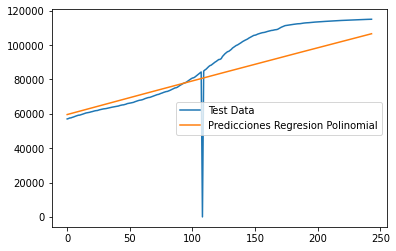

In [24]:
plt.plot(y_test_confirmados)
plt.plot(test_linear_confirmados)
plt.legend(['Test Data', 'Predicciones Regresion Polinomial'])

## RP: Para casos Fallecimientos

In [25]:
# Regresion Polinomial: Para Fallecimientos
linear_model_fallecidos = LinearRegression(normalize=True, fit_intercept=False)
linear_model_fallecidos.fit(poly_X_train_fallecidos, y_train_fallecidos)
test_linear_pred_fallecidos = linear_model_fallecidos.predict(poly_X_test_fallecidos)
linear_pred_fallecidos = linear_model_fallecidos.predict(poly_pronostico_futuro)
print('Error Absoluto Medio (MAE):', mean_absolute_error(test_linear_pred_fallecidos, y_test_fallecidos))
print('Error Cuadrático Medio(MSE):',mean_squared_error(test_linear_pred_fallecidos, y_test_fallecidos))

Error Absoluto Medio (MAE): 3597.8930547629466
Error Cuadrático Medio(MSE): 22918872.37952424


In [26]:
# Coeficientes estimados para el problema de regresión lineal
print(linear_model_fallecidos.coef_)

[[-3.27203643e+02  7.99750435e+00 -3.75558237e-03]]


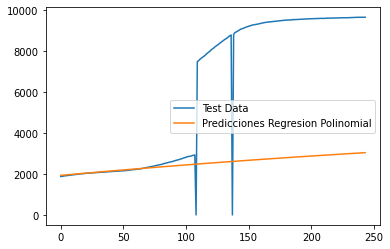

In [27]:
plt.plot(y_test_fallecidos)
plt.plot(test_linear_pred_fallecidos)
plt.legend(['Test Data', 'Predicciones Regresion Polinomial'])

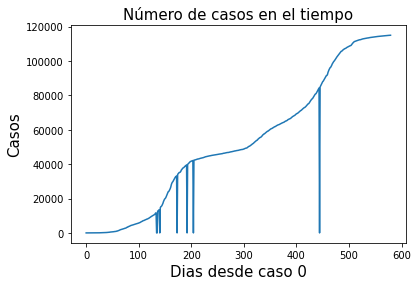

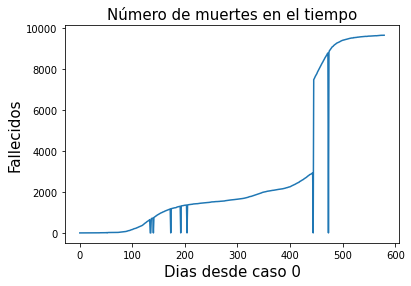

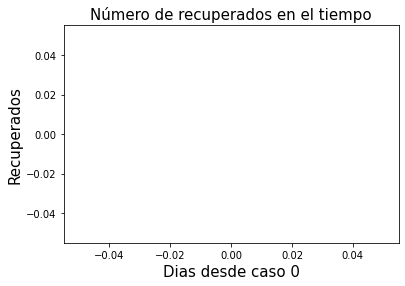

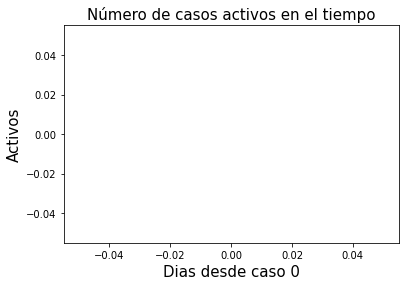

In [28]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, arequipa_casos)
plt.title('Número de casos en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Casos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, arequipa_fallecidos)
plt.title('Número de muertes en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Fallecidos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, arequipa_recuperados)
plt.title('Número de recuperados en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Recuperados', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#plt.figure(figsize=(8, 4.5))
plt.plot(adjusted_dates, arequipa_activos)
plt.title('Número de casos activos en el tiempo', size=15)
plt.xlabel('Dias desde caso 0', size=15)
plt.ylabel('Activos', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

## Visualización de las predicciones: SVM y Regresión Polinomial

In [29]:
def plot_predictions(x, y, pred, algo_name, color, title):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(pronostico_futuro, pred, linestyle='dashed', color=color)
    plt.title('Número de ' + title + ' en el tiempo', size=25)
    plt.xlabel('Días desde caso 0', size=25)
    plt.ylabel(title, size=25)
    plt.legend([ title +' confirmados', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

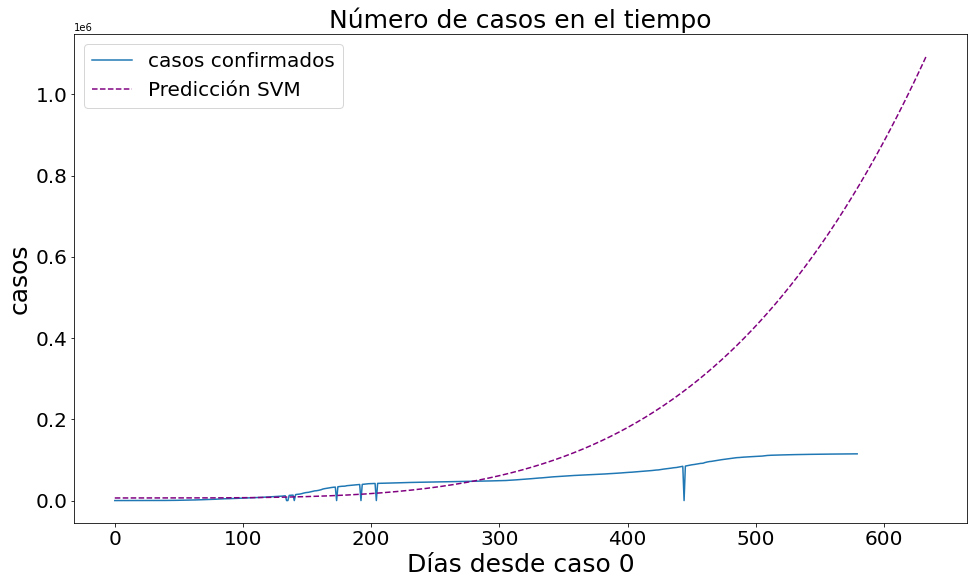

In [30]:
plot_predictions(adjusted_dates, arequipa_casos, svm_pred_confirmados, 'Predicción SVM', 'purple', 'casos')

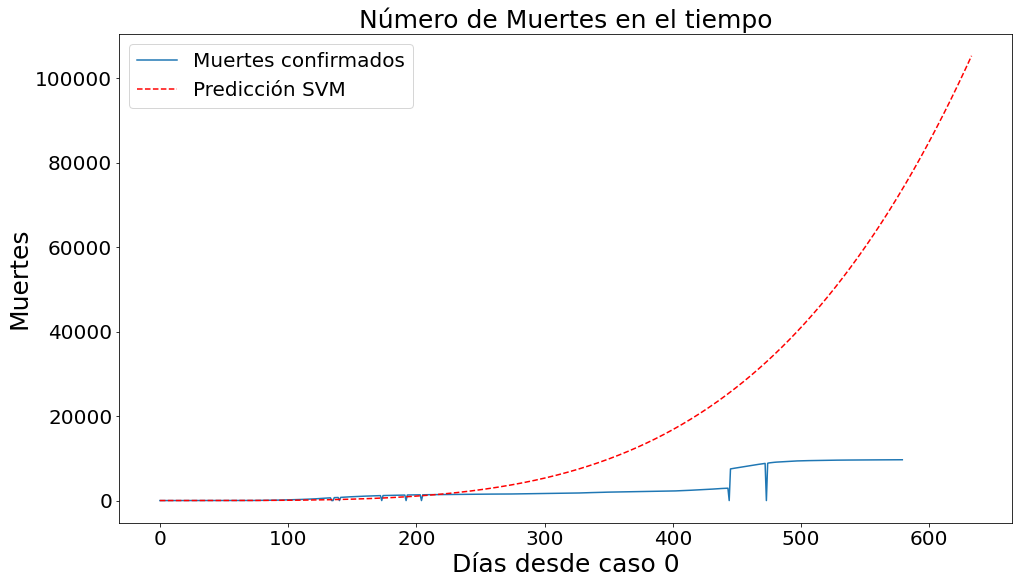

In [31]:
plot_predictions(adjusted_dates, arequipa_fallecidos, svm_pred_fallecidos, 'Predicción SVM', 'red', 'Muertes')

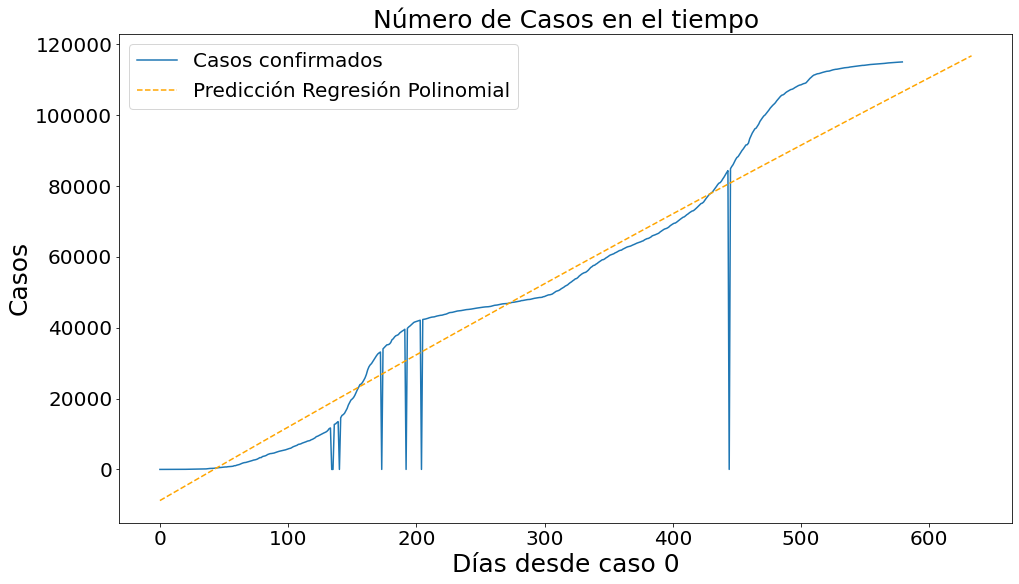

In [32]:
plot_predictions(adjusted_dates, arequipa_casos, linear_pred_confirmados, 'Predicción Regresión Polinomial', 'orange', 'Casos')

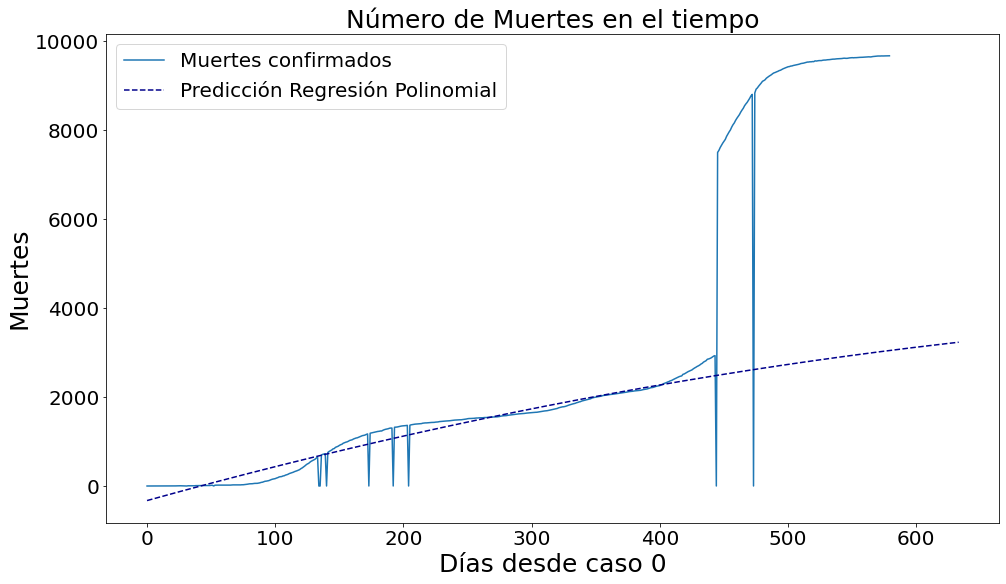

In [33]:
plot_predictions(adjusted_dates, arequipa_fallecidos, linear_pred_fallecidos, 'Predicción Regresión Polinomial', 'darkblue', 'Muertes')

In [37]:
# Predicciones futuras usando SVM
svm_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Casos': np.round(svm_pred_confirmados[:66]),'Muertes':np.round(svm_pred_fallecidos[:66])})
svm_df

,Fecha,Casos,Muertes
0,08/18/2021,6367.0,4.0
1,08/19/2021,6367.0,4.0
2,08/20/2021,6367.0,4.0
3,08/21/2021,6367.0,4.0
4,08/22/2021,6367.0,4.0
...,...,...,...
61,10/18/2021,6461.0,13.0
62,10/19/2021,6467.0,14.0
63,10/20/2021,6474.0,14.0
64,10/21/2021,6481.0,15.0


In [38]:
# Predicciones futuras usando Regresion Polinomial
linear_pred_confirmados = linear_pred_confirmados.reshape(1,-1)[0]
linear_pred_fallecidos = linear_pred_fallecidos.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Casos': np.round(linear_pred_confirmados[:66]),'Muertes':np.round(linear_pred_fallecidos[:66])})
svm_df

,Fecha,Casos,Muertes
0,08/18/2021,-8788.0,-327.0
1,08/19/2021,-8579.0,-319.0
2,08/20/2021,-8370.0,-311.0
3,08/21/2021,-8161.0,-303.0
4,08/22/2021,-7952.0,-295.0
...,...,...,...
61,10/18/2021,3907.0,147.0
62,10/19/2021,4114.0,154.0
63,10/20/2021,4321.0,162.0
64,10/21/2021,4528.0,169.0


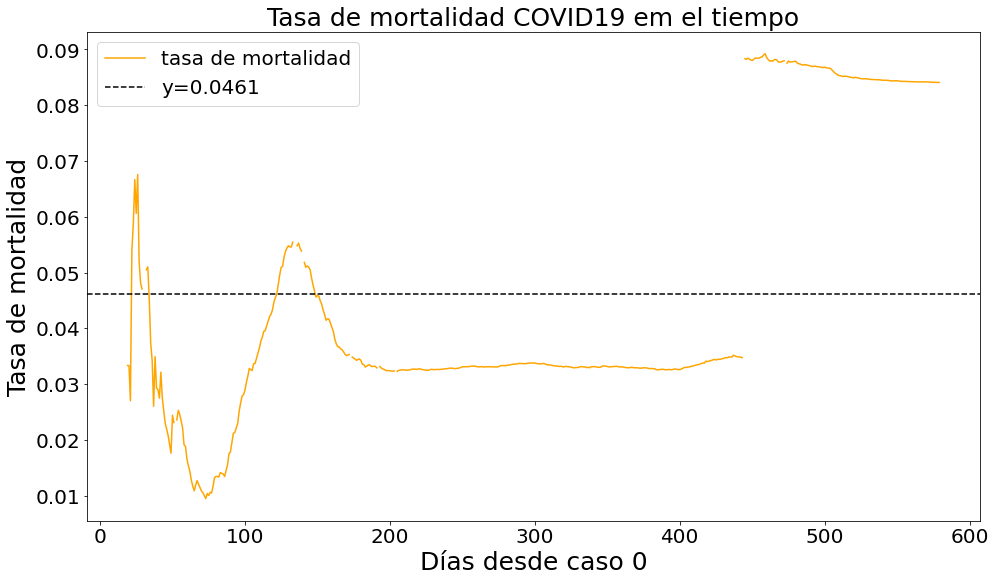

In [39]:
mean_tasa_mortalidad = np.round(np.nanmean(tasa_mortalidad),4)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, tasa_mortalidad, color='orange')
plt.axhline(y = mean_tasa_mortalidad,linestyle='--', color='black')
plt.title('Tasa de mortalidad COVID19 em el tiempo', size=25)
plt.legend(['tasa de mortalidad', 'y='+str(mean_tasa_mortalidad)], prop={'size': 20})
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel('Tasa de mortalidad', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


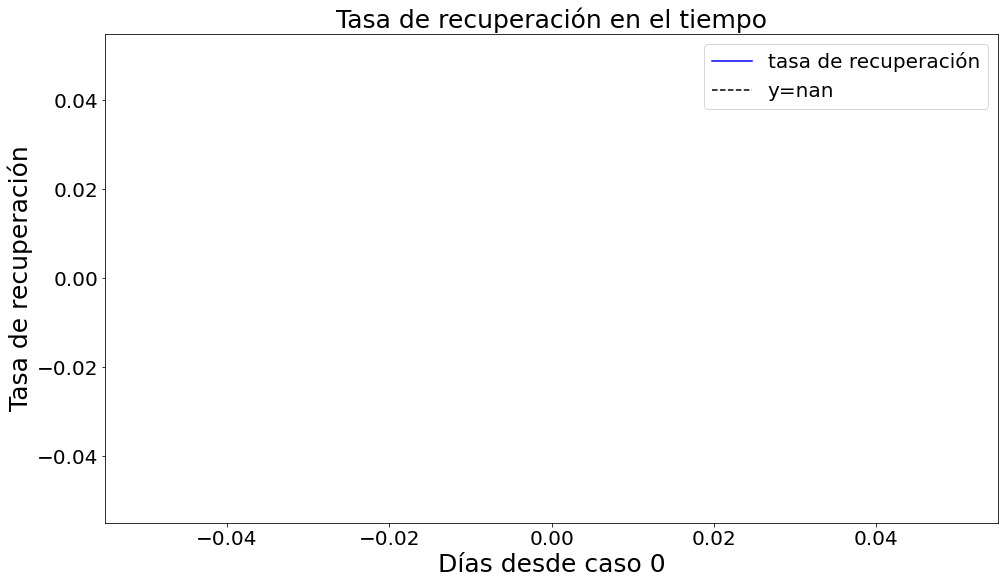

In [40]:
mean_tasa_recuperacion = np.round(np.nanmean(tasa_recuperacion),4)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, tasa_recuperacion, color='blue')
plt.axhline(y = mean_tasa_recuperacion,linestyle='--', color='black')
plt.title('Tasa de recuperación en el tiempo', size=25)
plt.legend(['tasa de recuperación', 'y='+str(mean_tasa_recuperacion)], prop={'size': 20})
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel('Tasa de recuperación', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# Programación: Regresión Lineal + Gradiente Descendiente


## 1.  Normalización con el Promedio (Buena Practica)
Nos ayuda a extender o comprimir los valores de la variable para que estén en un rango definido. Esto ayudará evitar que el modelo falle y aceleramos la convergencia

Función de Normalización:

$X_{i} = \frac{X_i - \mu_i}{S_i}$

donde:

  - $\mu_i$ : Media
  - $S_i$ : Desviación estándar

In [41]:
def Normalizar_Datos(data : np.array):
    normal = np.empty_like(data)
    for i in range (0,np.size(data[0])):
        media = np.mean(data[:,i])
        desvi =np.std(data[:,i])
        normal[:,i] = (data[:,i] - media)/desvi
    return normal, media, desvi

In [42]:
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, arequipa_casos, test_size=0.1, shuffle=False)
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, arequipa_fallecidos, test_size=0.1, shuffle=False)

In [43]:
X_train_fallecidos_n = X_train_fallecidos.astype('float64')
y_train_fallecidos_n = y_train_fallecidos.astype('float64')

X_train_fallecidos_n, med_X_train_fallecidos, des_X_train_fallecidos = Normalizar_Datos(X_train_fallecidos_n)
y_train_fallecidos_n, med_y_train_fallecidos, des_y_train_fallecidos = Normalizar_Datos(y_train_fallecidos_n)

## 2.  Calcular Costos
La función de costo nos ayuda que tan incorrecto es el modelo en terminos de su capacidad para estimar la relación entre X e y.

Función de Costo:

$J(\theta) = J(\theta_0, \theta_1, ..., \theta_n ) = \frac{1}{2m} \sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})^2$

Donde:

- Parámetros : $\theta_0, \theta_1, ..., \theta_n$ 
- Predicción : $h_{\theta}(x^{(i)})$
- Respuesta correcta : $y^{(i)}$

In [44]:
def Calcular_Costo(X: np.array, y: np.array, theta: np.array):
    m = np.size(X[:,0]) #numero de datos
    #Calculo de la Hipotesis : h(x)
    h = X.dot(theta.T)
    h = h - y
    return np.sum( np.square(h) ) / (2*m) , h

## 3.  Gradiente Descendiente
Una vez que definamos la función de costo para nuestro modelo, tendremos que averiguar cómo asignar valores a $\theta_j$ de manera que el error para nuestro modelo sea mínimo. Se comienza con algún valor de los parámetros y luego estos van a estar cambiando repetidamente los parámetros de modo que terminemos con un error minimo para nuestro conjunto de datos de entremaniento usando nuestra funcion de modelo.

Función de Gradiente Descendiente:

$\theta_j := \theta_j - \alpha \frac{\partial}{\partial\theta_j} J(\theta_0, \theta_1, ..., \theta_n )$

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)})-y^{(i)})x_j^{(i)}$

Donde: 

*   Tasa de Aprendizaje: $\alpha$ 

In [45]:
def Gradiente_Descendiente(X: np.array, y:np.array, theta:np.array,
                          num_itera:int, tasa_apren:float):
    m = np.size(X[:,0]) #numero de datos
    arr_costo = np.zeros(num_itera, dtype=float)   
    #Calculo con valor inicial
    arr_costo[0], h = Calcular_Costo(X, y, theta)
    #Iteraciones
    for itera in range(1,num_itera):
        theta = theta - ( tasa_apren * (np.dot(h, X)/m))      
        arr_costo[itera], h = Calcular_Costo(X, y, theta)
    return arr_costo, theta

In [46]:
def InicializarXo(X: np.array):
    #Funcion para Insertar Columna X0 = 1 
    one = np.ones( (len(X)) )
    return np.c_[ (one, X)]

## 4.  Ecuación Normal
Método para encontrar $\theta$ de forma analítica.

Función de la Ecuacion Normal:

$\theta = (X^T X)^{-1} X^{T}y$

Donde:
*  $X^T$: Es la transpuesta de $X$  
*  $(X^T X)^{-1}$: Es la inversa de la matriz $X^T X$

In [47]:
def Ecuacion_Normal(X :np.array , y:np.array):
    XT = np.transpose(X)
    return np.dot(np.dot( np.linalg.inv( np.dot(XT, X)) , XT) , y)

## 5.  Error Cuadrático Medio
Método para evaluar el error para ambos conjuntos.

Función de la RMS:

$E_{RMS} = \frac{1}{N} \sum_{i=1}^N (y_i - \widehat{y}_i)^2$

In [48]:
def Error_Cuadratico_Medio(x_test: np.array, y_test: np.array, theta:np.array):
    n = np.size(y_test)
    #y_calc = np.empty(n)
    y_calc = x_test.dot(theta)
    #print(x_test)
    return (np.sum(np.square(y_calc-y_test)))/n

In [49]:
#Valores Theta para Gradiente Descendiente
def CalculoTheta(X:np.array, y:np.array):
    y_train = []
    X_train = InicializarXo(X)
    for i in y:
        y_train.append(i[0])
 
    theta = np.zeros( (np.size(X_train[0])))
    dummy, theta = (Gradiente_Descendiente(X_train, y_train, theta,200, 0.2))
    
    theta_ec = Ecuacion_Normal(X_train, y_train)
    # Como se esta comportando mi modelo
    error = Error_Cuadratico_Medio(X_train, y_train, theta)
    return theta, theta_ec, error, dummy

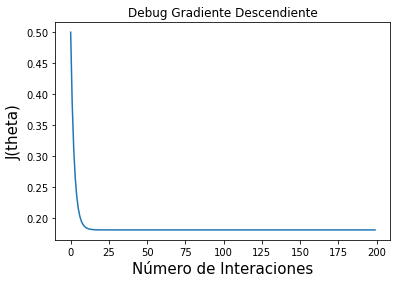

array([5.60641359e-17, 7.98948759e-01])

In [50]:
theta_calc, theta_ec, error, cost_history = CalculoTheta(X_train_fallecidos_n, y_train_fallecidos_n)
plt.title("Debug Gradiente Descendiente")
plt.plot(cost_history)
plt.xlabel('Número de Interaciones', size=15)
plt.ylabel('J(theta)', size=15)
plt.show()
#Valores theta por la gradiente descendiente
theta_calc

In [51]:
# Valores theta por la Ec. Normal
theta_ec, error

(array([1.97758476e-16, 7.98948759e-01]), 0.3616808802439342)

In [52]:
# Preparacion de data para prediccion
pronostico_futuro_n = pronostico_futuro.astype('float64')
# Normalización
pronostico_futuro_n = (pronostico_futuro_n - med_X_train_fallecidos)/des_X_train_fallecidos
# Por conveniencia: Agregamos el X_0 = 1
pronostico_futuro_n = InicializarXo(pronostico_futuro_n)
# Hipotesis
y_pred_fallecidos = pronostico_futuro_n.dot(theta_calc)
# Desnormalizamos
y_pred_fallecidos = (y_pred_fallecidos * des_y_train_fallecidos)+med_y_train_fallecidos

In [53]:
#Presentacion de Resultados
y_pred_fallecidos_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:11], 'Muertes':np.round(y_pred_fallecidos[:11])})
y_pred_fallecidos_df

,Fecha,Muertes
0,08/18/2021,-1592.0
1,08/19/2021,-1577.0
2,08/20/2021,-1562.0
3,08/21/2021,-1547.0
4,08/22/2021,-1532.0
5,08/23/2021,-1517.0
6,08/24/2021,-1502.0
7,08/25/2021,-1487.0
8,08/26/2021,-1472.0
9,08/27/2021,-1457.0


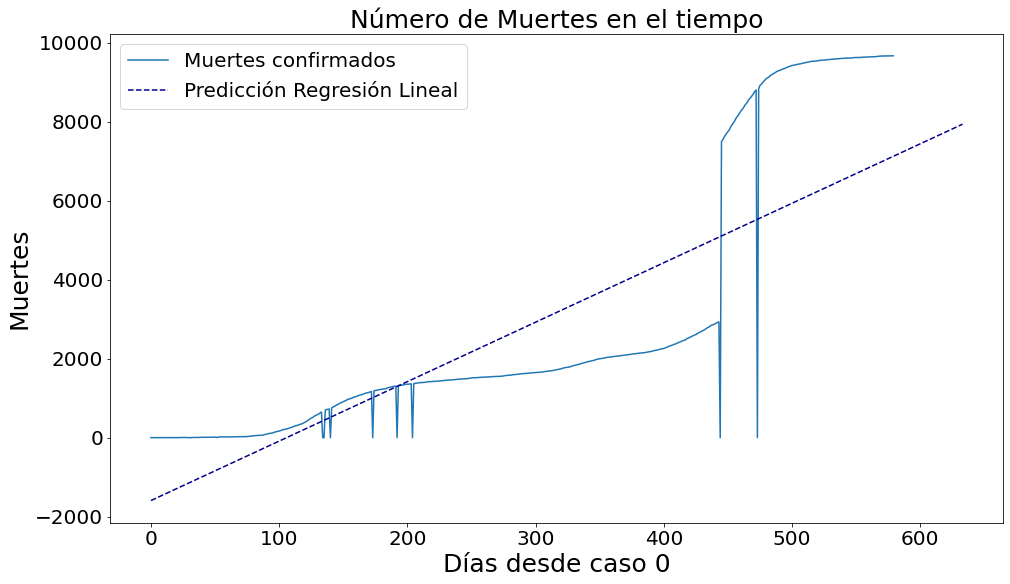

In [54]:
plot_predictions(adjusted_dates, arequipa_fallecidos, y_pred_fallecidos, 'Predicción Regresión Lineal', 'darkblue', 'Muertes')

In [55]:
#Toma de data para Regresion lineal multiple
X_train_fallecidos, X_test_fallecidos, y_train_fallecidos, y_test_fallecidos = train_test_split(days_since_18_8, arequipa_fallecidos, test_size=0.1, shuffle=False)
X_train_confirmados, X_test_confirmados, y_train_confirmados, y_test_confirmados = train_test_split(days_since_18_8, arequipa_casos, test_size=0.1, shuffle=False)

In [56]:
#Preparacion de data para Regresion lineal multiple
X_train_confirmados = X_train_confirmados.astype('float64')
y_train_confirmados = y_train_confirmados.astype('float64')

X_train_confirmados_n, mid_X_train, svi_X_train = Normalizar_Datos(X_train_confirmados)
y_train_confirmados_n, mid_y_train, svi_y_train = Normalizar_Datos(y_train_confirmados)

X_train_fecha_conf = np.c_[ (X_train_confirmados_n, y_train_confirmados_n)]
#X_train_fecha_conf

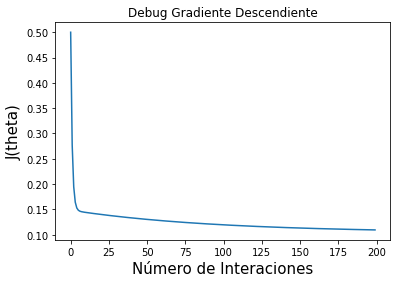

(array([ 1.50496899e-16, -4.21955922e-01,  1.26604292e+00]),
 0.21906047355443825)

In [57]:
theta_n , theta_ec_n, error_n, cost_history_n = CalculoTheta(X_train_fecha_conf, y_train_fallecidos_n)
plt.title("Debug Gradiente Descendiente")
plt.plot(cost_history_n)
plt.xlabel('Número de Interaciones', size=15)
plt.ylabel('J(theta)', size=15)
plt.show()
#Valores theta por la gradiente descendiente
theta_n, error_n

In [58]:
#Utilizamos la data de la prediccion de SVM para completar data para prediccion
#Normalizamos
svm_pred_n = (svm_pred_confirmados - mid_y_train)/svi_y_train
#svm_pred_n

In [59]:
#Preparamos X para calculo de y prediccion
x_future_calc_n = np.c_[(pronostico_futuro_n, svm_pred_n)]
#x_future_calc_n

In [60]:
#Prediccion 
y_future_calc_n = x_future_calc_n.dot(theta_n)
#y_future_calc_n

In [61]:
#Desnormalizacion y Presentacion de Resultados
y_future_calc_n = (y_future_calc_n * des_y_train_fallecidos) + med_y_train_fallecidos

y_multi_death_df = pd.DataFrame({'Fecha': fechas_pronostico_futuras[:66], 'Muertes':np.round(y_future_calc_n[:66])})
y_multi_death_df

,Fecha,Muertes
0,08/18/2021,209.0
1,08/19/2021,201.0
2,08/20/2021,193.0
3,08/21/2021,185.0
4,08/22/2021,177.0
...,...,...
61,10/18/2021,-266.0
62,10/19/2021,-273.0
63,10/20/2021,-280.0
64,10/21/2021,-287.0


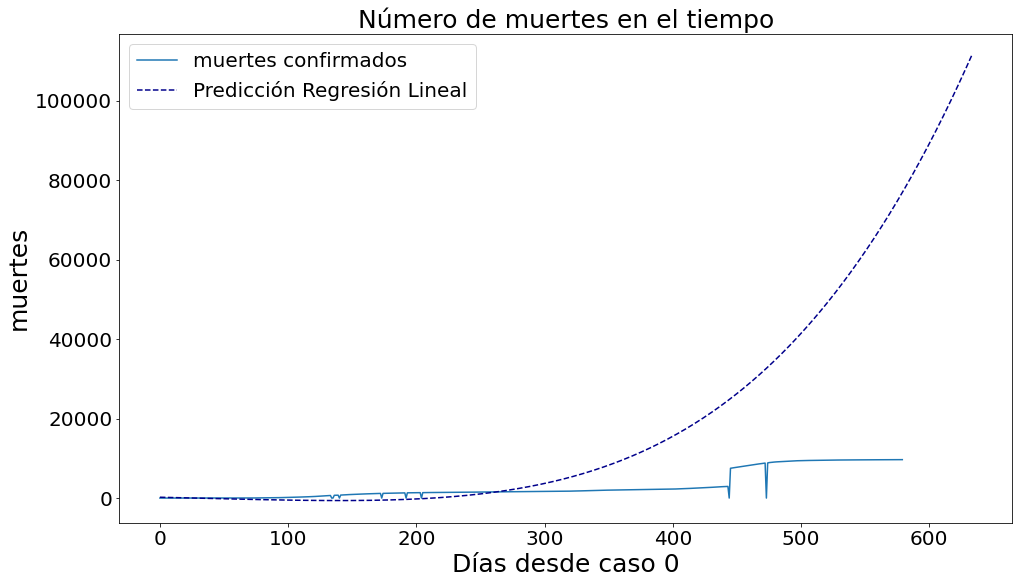

In [62]:
plot_predictions(adjusted_dates, arequipa_fallecidos, y_future_calc_n, 'Predicción Regresión Lineal', 'darkblue', 'muertes')

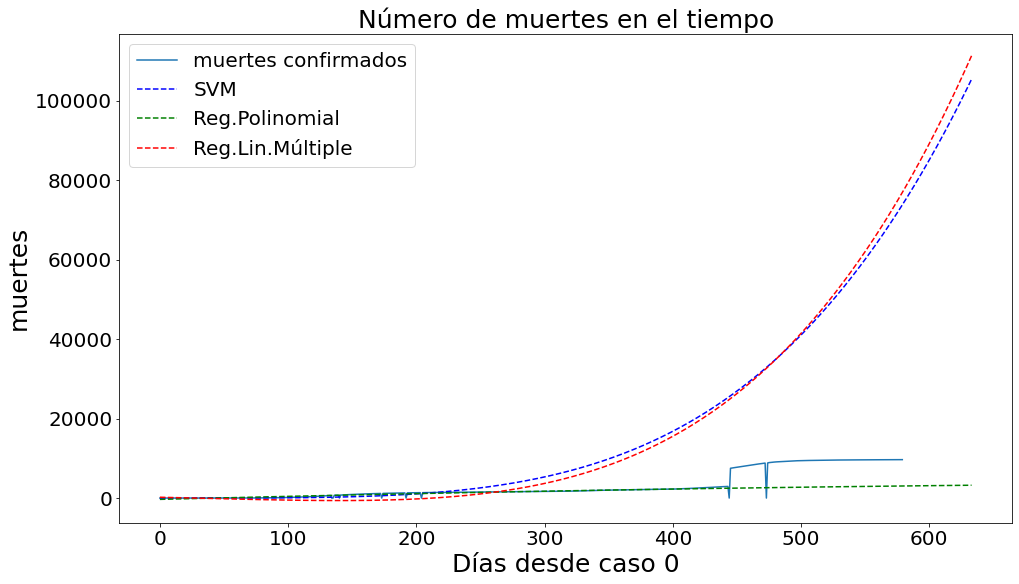

In [63]:
x = adjusted_dates
y = arequipa_fallecidos

algo_name1 = 'SVM'
algo_name2 = 'Reg.Polinomial'
algo_name3 = 'Reg.Lin.Múltiple'
title = 'muertes'
plt.figure(figsize=(16, 9))
plt.plot(x, y)
plt.plot(pronostico_futuro, svm_pred_fallecidos, linestyle='dashed', color='blue')
plt.plot(pronostico_futuro, linear_pred_fallecidos, linestyle='dashed', color='green')
plt.plot(pronostico_futuro, y_future_calc_n, linestyle='dashed', color='red')

#y_future_calc_n

plt.title('Número de ' + title + ' en el tiempo', size=25)
plt.xlabel('Días desde caso 0', size=25)
plt.ylabel(title, size=25)

plt.legend([title +' confirmados', algo_name1, algo_name2, algo_name3], prop={'size': 20})
#plt.legend([ title +' confirmados', algo_name2], prop={'size': 20})

plt.xticks(size=20)
plt.yticks(size=20)
plt.show()